# Comparing samplers for a simple problem

We'll use the previous notebook on "Parameter estimation example: Gaussian noise and averages".

We used the affine-invariant sampler standalone `emcee` before. Here we'll compare to using another standalone sampler, `zeus`, and the probabilistic programming language `PyMC`. 

##  Original background

Adapted from Sivia: *Data Analysis: A Bayesian Tutorial*

Here we'll take a look at a simple parameter-estimation problem. We will compare the frequentist and Bayesian approaches. This problem is an extended version of Example 2 in Ch 2.3 of the book by Sivia. This short book is very readable and is highly recommended.

This notebook was adapted from a broad introduction to Bayesian statistics put together by Christian Forssen for the 2019 TALENT school on ["Learning from Data"](https://nucleartalent.github.io/Bayes2019/).

## Common set up and generating data for all samplers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

# Not really needed, but nicer plots
# import seaborn as sns
# sns.set()      
# sns.set_context("talk")

Let us consider the problem of estimating the mean and the variance of a normal distribution that is associated with a collection of random variables. The normal distribution
$$
p(x|\mu,\sigma) = \frac{1}{\sqrt{2\pi}\sigma} \exp \left(-\frac{(x-\mu)^2}{2\sigma^2} \right),
$$
is often used as a theoretical model to describe the noise associated with experimental data.

*Why is a normal (Gaussian) distribution so often a good statistical model?* 


Let us assume that we have a series of $M$ measurements $D \equiv \{ x_k \} = (x_1, \ldots, x_M)$, that are samples from a normal $\mathcal{N}(\mu, \sigma^2)$ population, from which we would like to learn the approximate values of the parameters $\mu$ and $\sigma$. The standard frequentist approach to this problem is the maximum likelihood method. The Bayesian approach is to compute the posterior distribution for the model parameters $\mu$ and $\sigma$.

Here we'll use Python to generate some toy data to demonstrate the two approaches to the problem. 

In [2]:
# Generating some data
np.random.seed(10)  # for repeatability

mu_true = 10   # true peak position 
sigma_true = 1 # true standard deviation 
M = 100 # number of measurements
D = stats.norm.rvs(mu_true, sigma_true, size=M)  # M measurements (samples)

**Side note:** try shift-tab-tab to get documentation!

*Look at the array `D`.  Are the number of entries in the "tails" what you would expect?*  

In [3]:
D

array([11.3315865 , 10.71527897,  8.45459971,  9.99161615, 10.62133597,
        9.27991444, 10.26551159, 10.10854853, 10.00429143,  9.82539979,
       10.43302619, 11.20303737,  9.03493433, 11.02827408, 10.22863013,
       10.44513761,  8.86339779, 10.13513688, 11.484537  ,  8.92019511,
        8.02227172,  8.2566277 , 10.26607016, 12.38496733, 11.12369125,
       11.67262221, 10.09914922, 11.39799638,  9.72875201, 10.61320418,
        9.73268281,  9.45069099, 10.1327083 ,  9.52385799, 11.30847308,
       10.19501328, 10.40020999,  9.66236766, 11.25647226,  9.2680305 ,
       10.66023155,  9.64912811,  9.06056664,  9.51066278,  9.19540886,
        9.78730236,  9.66085975, 10.31216994, 10.56515267,  9.85257974,
        9.97409466, 10.2890942 ,  9.46012093, 10.70816002, 10.84222474,
       10.2035808 , 12.39470366, 10.91745894,  9.88772753,  9.63781955,
        9.76781774,  9.4982711 , 11.12878515,  9.30218997,  9.91887782,
        9.47070392, 11.04618286,  8.58144397,  9.63750082,  9.87

*Hint: Roughly how many entries do you expect to find two sigma away from the mean?*

Let's verify your answer with visualizations!

First, let's make two simple visualizations of the "measured" data: a scatter plot and a histogram

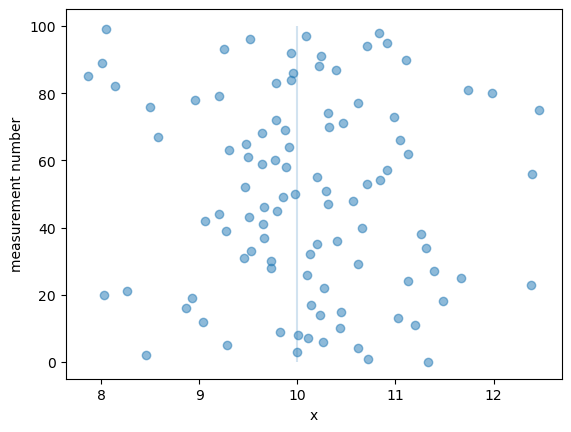

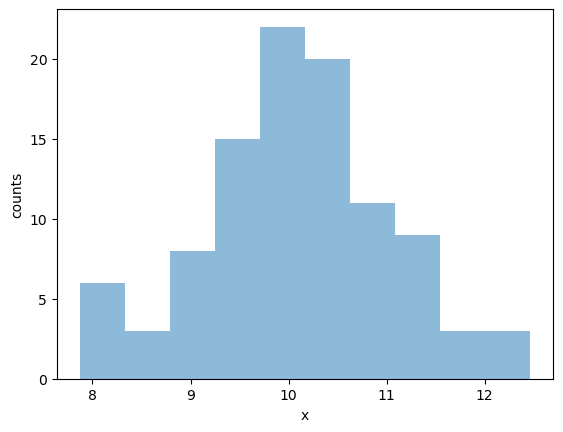

In [4]:
fig1, ax1 = plt.subplots()
ax1.scatter(D, np.arange(M), alpha=0.5)
ax1.vlines([mu_true], 0, M, alpha=0.2)
ax1.set_xlabel("x"); ax1.set_ylabel("measurement number");

fig2, ax2 = plt.subplots()
ax2.hist(D,alpha   =0.5)
#ax1.vlines([mu_true], 0, M, alpha=0.2)
ax2.set_xlabel("x"); ax2.set_ylabel("counts");


`Matplotlib` alternative: one figure with two subplots using an array of axes.

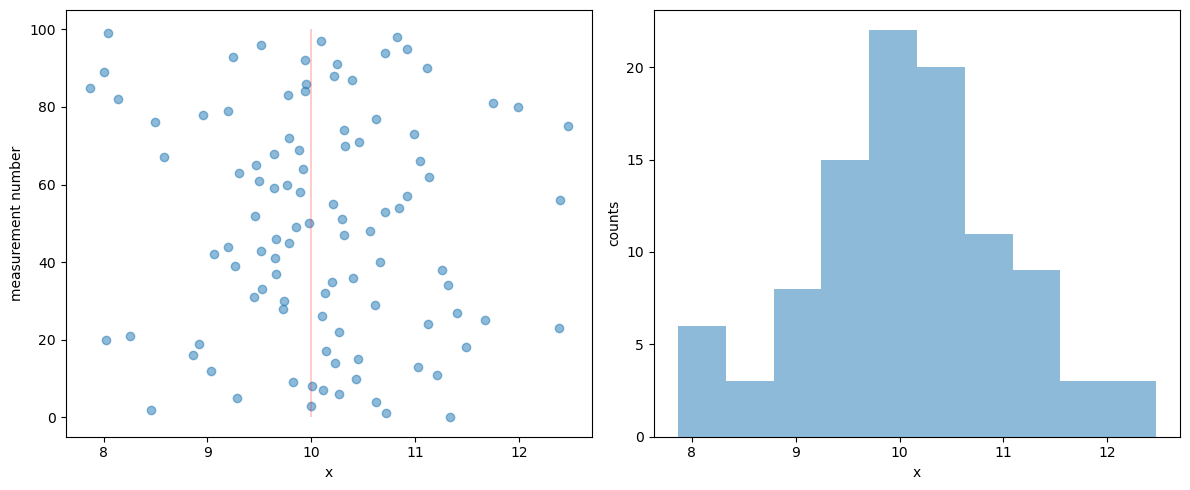

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
# An alternative keeping the same axis names as before would be:
#  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

axes[0].scatter(D, np.arange(M), alpha=0.5)
axes[0].vlines([mu_true], 0, M, color='red', alpha=0.2)
axes[0].set_xlabel("x"); axes[0].set_ylabel("measurement number");

axes[1].hist(D,alpha=0.5)
axes[1].set_xlabel("x"); axes[1].set_ylabel("counts");

fig.tight_layout()

*What can you conclude about the tails?*

*Change np.random.seed(1) to a different number so that a different set of random numbers is generated.*

## Frequentist approach to Gaussian parameter estimation

We'll start with the classical frequentist **maximum likelihood** approach. The probability of a single measurement $D_i$ having a value $x_i$ is given by 

$$ p(x_i~|~\mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp{\left[\frac{-(x_i - \mu)^2}{2 \sigma^2}\right]}, $$

where $\mu$, $\sigma$ are the *true* values for the model parameters.

We construct the **likelihood function** by computing the product of the probabilities for each data point:

$$\mathcal{L}(D~|~\mu, \sigma) = \prod_{i=1}^M p(x_i~|~\mu, \sigma)$$




Because the value of the likelihood can become very small, it is often more convenient to instead compute the log-likelihood. Furthermore, when we are looking for the maximum of the likelihood, we might just as well maximize the log-likelihood. Combining the previous two equations and computing the log, we have

$$\log\mathcal{L} = -\frac{1}{2} \sum_{i=1}^M \left[ \log(2\pi  \sigma^2) + \frac{(x_i - \mu)^2}{\sigma^2} \right]$$

What we'd like to do is find $\mu_0,\sigma_0$ such that the likelihood (or log likelihood) is maximized. For this simple problem, the maximization can be computed analytically (i.e. by setting $\left. \partial\log\mathcal{L}/\partial\mu \right|_{\mu_0,\sigma_0} = \left. \partial\log\mathcal{L}/\partial\sigma \right|_{\mu_0,\sigma_0} = 0$).  This results in the following *maximum-likelihood estimates* of the true parameters:

$$ 
\mu_0 = \frac{1}{M}\sum_{i=1}^M x_i \\
\sigma_0^2 = \frac{1}{M}\sum_{i=1}^M (x_i - \mu_0)^2
$$

In principle, we should also compute the second derivatives to make sure that this point represents a maximum rather than a minimum or a saddle point. However, in agreement with intuition, $\mu_0$ is simply the mean of the observed data. These results are fairly simple calculations; let's evaluate them for our toy dataset:

In [6]:
# Estimators: sample mean and (sqrt of) sample variance
# Sometimes the *unbiased* estimator for the sample variance is used 
# with (M-1) degrees of freedom...
mu_est = D.sum()/M
sigma_est = np.sqrt(((D-mu_est)**2).sum()/M)
print("""
      (mu,sigma)_true = {0:.2f}, {1:.2f}
      
      Sample estimators: 
      (mu,sigma)_0  = {2:.2f}, {3:.2f} (based on {4} measurements)
      """.format(mu_true, sigma_true, mu_est, sigma_est, M))


      (mu,sigma)_true = 10.00, 1.00
      
      Sample estimators: 
      (mu,sigma)_0  = 10.08, 0.97 (based on 100 measurements)
      


**Aside:** using `fstrings` by putting an `f` in front of the quotes.

In [7]:
# Estimators: sample mean and (sqrt of) sample variance
# Sometimes the *unbiased* estimator for the sample variance is used with 
# (M-1) degrees of freedom...
mu_est = D.sum()/M
sigma_est = np.sqrt(((D-mu_est)**2).sum()/M)
print(f"""
      (mu,sigma)_true = {mu_true:.2f}, {sigma_true:.2f}
      
      Sample estimators:
      (mu,sigma)_0 = {mu_est:.2f}, {sigma_est:.2f} (based on {M} measurements)
      """)


      (mu,sigma)_true = 10.00, 1.00
      
      Sample estimators:
      (mu,sigma)_0 = 10.08, 0.97 (based on 100 measurements)
      


## Bayesian approach to Gaussian parameter estimation
The Bayesian approach begins and ends with probabilities (pdfs).  It recognizes that what we fundamentally want to compute is our knowledge of the parameters in question, i.e. in this case,

$$ p(\mu,\sigma~|~D, I) $$

Note that this formulation of the problem is *fundamentally contrary* to the frequentist philosophy, which says that *probabilities have no meaning for model parameters* like $\mu,\sigma$. Nevertheless, within the Bayesian philosophy this is perfectly acceptable. 

To compute this result, Bayesians next apply [Bayes' Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem), here with the hypothesis being the Gaussian model expressed in terms of the model parameters

$$ p(\mu,\sigma~|~D, I) = \frac{p(D~|~\mu,\sigma, I)~p(\mu,\sigma~|~I)}{p(D~|~I)} $$

Though Bayes' theorem is where Bayesians get their name, it is not this law itself that is controversial, but the Bayesian *interpretation of probability* implied by the term $p(\mu,\sigma~|~D, I)$.

Let's take a look at each of the terms in this expression:

- $p(\mu,\sigma~|~D, I)$: The **posterior**, or the probability of the model parameters given the data: this is the result we want to compute.
- $p(D~|~\mu,\sigma, I)$: The **likelihood**, which is proportional to the $\mathcal{L}(D~|~\mu,\sigma)$ in the frequentist approach, above.
- $p(\mu,\sigma~|~I)$: The **model prior**, which encodes what we knew about the model prior to the application of the data $D$.
- $p(D~|~I)$: The **data probability**, which in practice amounts to simply a normalization term.

If we set the prior $p(\mu,\sigma~|~I) \propto 1$ (a *flat prior*), we find

$$p(\mu,\sigma~|~D,I) \propto \mathcal{L}(D|\mu,\sigma)$$

and the Bayesian probability is maximized at precisely the same value as the frequentist result! So despite the philosophical differences, we see that (for this simple problem at least) the Bayesian and frequentist point estimates are equivalent.

### But what about the prior?
You'll noticed that we glossed over something here: the prior, $p(\mu,\sigma)$. The choice of prior will be discussed <span style="color:red">repeatedly</span> in the course, but we can already note that it allows inclusion of other information into the computation. This feature becomes very useful in cases where multiple measurement strategies are being combined to constrain a single model. The necessity to specify a prior, however, is one of the more controversial pieces of Bayesian analysis.

A frequentist will point out that the prior is problematic when no true prior information is available. Though it might seem straightforward to use a **noninformative prior** like the flat prior mentioned above, there are some [surprisingly subtleties](http://normaldeviate.wordpress.com/2013/07/13/lost-causes-in-statistics-ii-noninformative-priors/comment-page-1/) involved. It turns out that in many situations, a truly noninformative prior does not exist! Frequentists point out that the subjective choice of a prior which necessarily biases your result has no place in statistical data analysis.

A Bayesian would counter that frequentism doesn't solve this problem, but simply skirts the question. Frequentism can often be viewed as simply a special case of the Bayesian approach for some (implicit) choice of the prior: a Bayesian would say that it's better to make this implicit choice explicit, even if the choice might include some subjectivity.

### Applying the Bayesian approach
Leaving these philosophical debates aside for the time being, let's address how Bayesian results are generally computed in practice. For a one parameter problem like the one considered here, it's as simple as computing the posterior probability $p(\mu,\sigma~|~D,I)$ as a function of $\mu,\sigma$: this is the distribution reflecting our knowledge of the parameter $\mu,\sigma$. But as the dimension of the model grows, this direct approach becomes increasingly intractable. For this reason, Bayesian calculations often depend on sampling methods such as [Markov Chain Monte Carlo (MCMC)](http://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo). 

We won't go into the details of the theory of MCMC here (again, we will be discussing this topic during the course). Instead we will show a practical example of applying an MCMC approach using Dan Foreman-Mackey's excellent [emcee](http://dan.iel.fm/emcee/current/)  package.  Keep in mind here that the goal is to *generate a set of points drawn from the posterior probability distribution*, and to use those points to determine the answer we seek.

To perform this MCMC, we start by defining Python functions for the prior $p(\mu,\sigma~|~I)$, the likelihood $p(D~|~\mu,\sigma, I)$, and the posterior $p(\mu,\sigma~|~D,I)$, noting that none of these need be properly normalized. Our model here is two-dimensional so we'll define the model in terms of an array of parameters $\theta$, which in this case is $\theta = [\mu,\sigma]$:

In [8]:
min_theta=np.array([0,0])
max_theta=np.array([100,10])
volume_theta=np.prod(max_theta-min_theta)

def log_prior(theta):
    '''Log prior for parameter array theta'''
    assert len(theta)==2, "Parameter vector must have length two."
    # flat prior 
    if np.logical_and(min_theta<=theta, theta<=max_theta).all(): 
        return np.log(1/volume_theta)
    else:
        return -np.inf

def log_likelihood(theta, X):
    '''Log likelihood for data X given parameter array theta'''
    try:
        return -0.5 * np.sum( ( (X - theta[0]) / theta[1] )** 2 ) \
               - 0.5*len(X)*np.log(2*np.pi*theta[1]**2)
    except ValueError:
        return -np.inf

def log_posterior(theta, X):
    '''Log posterior for data X given parameter array theta'''
    return log_prior(theta) + log_likelihood(theta, X)

Now we set up the problem, including generating some random starting guesses for the multiple chains of points.

## First sample with `emcee`

In [9]:
# Modules needed for example: emcee is for MCMCsampling, corner for plotting
import emcee
import corner  # can be used with any sampler

In [10]:
ndim = 2  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 1000  # number of MCMC steps to take

# we'll start at random locations within the prior volume
starting_guesses = min_theta + \
                   (max_theta - min_theta) * np.random.rand(nwalkers,ndim)

print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[D])

# "burn-in" period; save final positions and then reset
pos, prob, state = sampler.run_mcmc(starting_guesses, nburn)
sampler.reset()

# sampling period
sampler.run_mcmc(pos, nsteps)

print("Mean acceptance fraction: {0:.3f} (in total {1} steps)"
                .format(np.mean(sampler.acceptance_fraction),nwalkers*nsteps))

# discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
samples = sampler.chain.reshape((-1, ndim))

MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.719 (in total 50000 steps)


If this all worked correctly, the array *samples* should contain a series of draws from the posterior. Let's plot them using a so called corner plot (to be discussed in much more detail during the course).

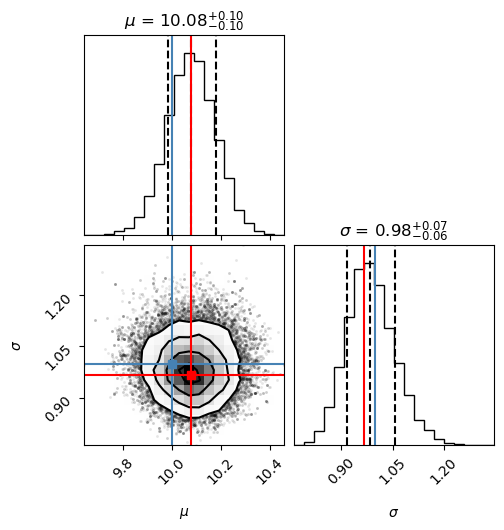

In [11]:
# make a corner plot with the posterior distribution
fig = corner.corner(samples, labels=["$\mu$", "$\sigma$"],
                    truths=[mu_true, sigma_true],quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12})

# With some manual efforts, we can add the maximum-likelihood estimate from 
#  the frequentist analysis.           
maxlike_results = (mu_est,sigma_est)

# First, extract the axes
axes = np.array(fig.axes).reshape((ndim, ndim))

# Then, loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(maxlike_results[i], color="r")

# And finally, loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(maxlike_results[xi], color="r")
        ax.axhline(maxlike_results[yi], color="r")
        ax.plot(maxlike_results[xi], maxlike_results[yi], "sr")

The lower left panel in the corner plot shows the joint probability distribution for the two model parameters. The two plots on the diagonal show marginalized distributions (with one parameter integrated out) for the two model parameters. The blue lines indicate the *true* values of the model parameters, while the title and the dashed lines indicate the most probable value as well as a 68% confidence interval. We will be discussing these representative measures of a posterior distribution during the course. 

The frequentist maximum-likelihood estimate from before is indicated by the red lines (that we added manually to the plot). As you can see, for this particular setup the maximum-likelihood estimate agrees with the most probable value from the MCMC sampling of the Bayesian posterior distribution.

The pure Bayesian result for a problem like this, however, would be to report the posterior distribution itself (i.e. its representative sample), and leave it at that. That is, in pure Bayesianism the answer to a question is not a single number with error bars; the answer is the posterior distribution over the model parameters! 

## Now sample with `zeus`

zeus is a slice sampler. See [https://zeus-mcmc.readthedocs.io/en/latest/index.html](https://zeus-mcmc.readthedocs.io/en/latest/index.html).

In [12]:
import zeus

In [13]:
ndim = 2  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 1000  # number of MCMC steps to take


# we'll start at random locations within the prior volume
starting_guesses = min_theta + \
                   (max_theta - min_theta) * np.random.rand(nwalkers,ndim)


# Do the burn-in with nburn steps
sampler = zeus.EnsembleSampler(nwalkers, ndim, log_posterior, args=[D])
sampler.run_mcmc(starting_guesses, nburn)

# Get the burn-in samples
burnin = sampler.get_chain()

# reset the start
starting_guesses = burnin[-1]

# now do the post-burn-in sampling with nsteps steps
sampler = zeus.EnsembleSampler(nwalkers, ndim, log_posterior, args=[D])
sampler.run_mcmc(starting_guesses, nsteps)


Initialising ensemble of 50 walkers...
Sampling progress : 100%|███████████████████| 1000/1000 [00:12<00:00, 78.43it/s]
Initialising ensemble of 50 walkers...
Sampling progress : 100%|██████████████████| 1000/1000 [00:05<00:00, 194.39it/s]


In [14]:
chain = sampler.get_chain(flat=True, discard=0, thin=1)
chain.shape

(50000, 2)

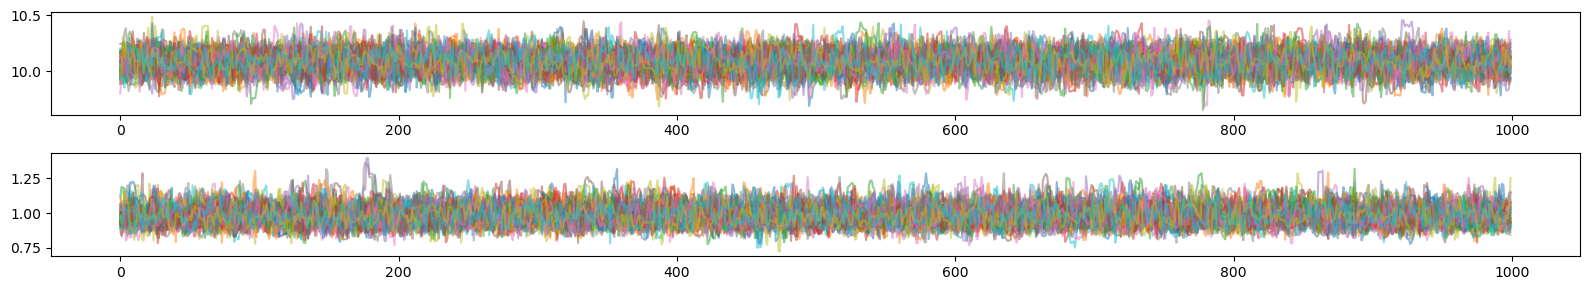

In [15]:
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler.get_chain()[:,:,n],alpha=0.5)
    #plt.plot(chain[:,n],alpha=0.5)
    #plt.axhline(y=mu[n])
plt.tight_layout()
plt.show()

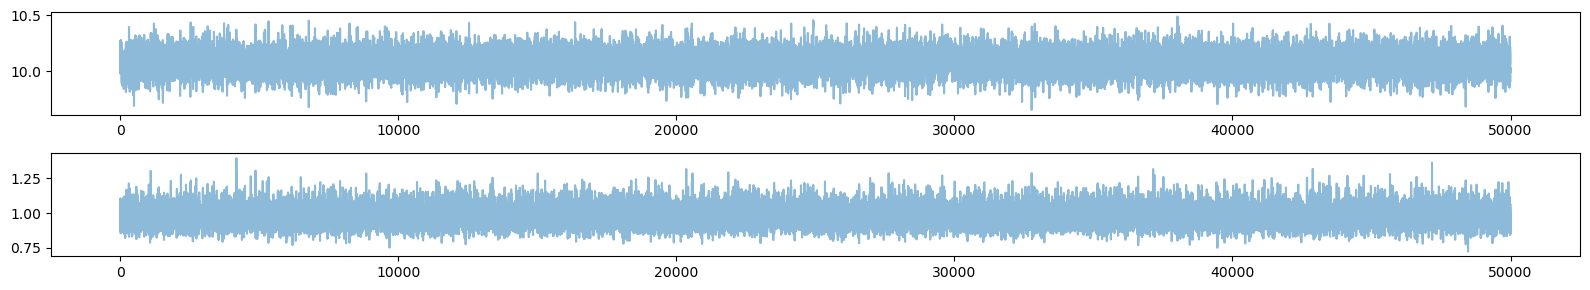

In [16]:
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    #plt.plot(sampler.get_chain()[:,:,n],alpha=0.5)
    plt.plot(chain[:,n],alpha=0.5)
    #plt.axhline(y=mu[n])
plt.tight_layout()
plt.show()

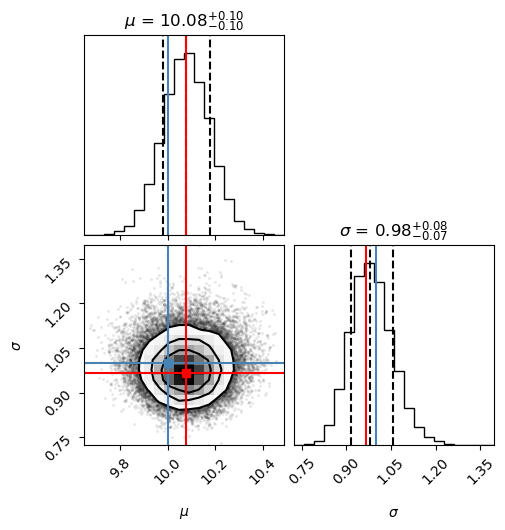

In [17]:
# make a corner plot with the posterior distribution
fig = corner.corner(chain, labels=["$\mu$", "$\sigma$"],
                    truths=[mu_true, sigma_true], quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12})

# With some manual efforts, we can add the maximum-likelihood estimate from 
#  the frequentist analysis.           
maxlike_results = (mu_est,sigma_est)

# First, extract the axes
axes = np.array(fig.axes).reshape((ndim, ndim))

# Then, loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(maxlike_results[i], color="r")

# And finally, loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(maxlike_results[xi], color="r")
        ax.axhline(maxlike_results[yi], color="r")
        ax.plot(maxlike_results[xi], maxlike_results[yi], "sr")

/Users/furnstah/Dropbox/Anaconda/anaconda3/envs/8820-env/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/Users/furnstah/Dropbox/Anaconda/anaconda3/envs/8820-env/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


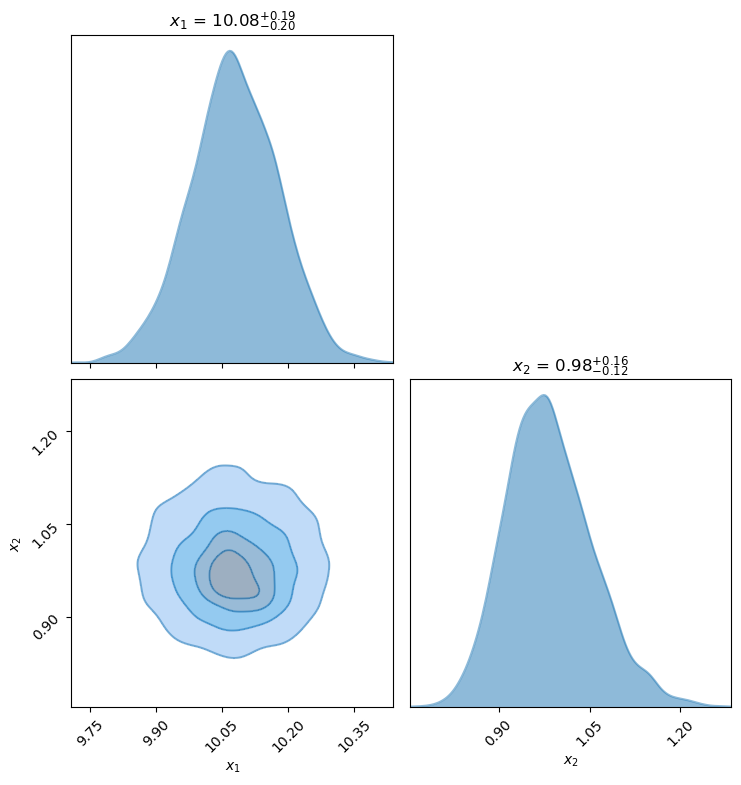

In [18]:
# Try the zeus corner plot routine, using every 10
fig, axes = zeus.cornerplot(chain[::10], size=(8,8))

In [19]:
# If we use all the points, this will take a long time
# fig, axes = zeus.cornerplot(chain, size=(8,8))

## Now sample with PyMC

The setup here is different.

In [20]:
import pymc as pm
import arviz as az

print('Running on PyMC v{}'.format(pm.__version__))

Running on PyMC v5.10.4


In [21]:
Gaussian_model = pm.Model()

with Gaussian_model:

    # Priors for mu and sigma
    mu = pm.Uniform("mu", lower=min_theta[0], upper=max_theta[0])
    sigma = pm.Uniform("sigma", lower=min_theta[0], upper=max_theta[0])

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=D)

In [22]:
map_estimate = pm.find_MAP(model=Gaussian_model)
    
map_estimate

{'mu_interval__': array(-2.18843153),
 'sigma_interval__': array(-4.62896866),
 'mu': array(10.07941624),
 'sigma': array(0.9670395)}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,10.080,0.098,9.891,10.262,0.002,0.001,3970.0,2471.0,1.0
sigma,0.984,0.069,0.862,1.116,0.001,0.001,4161.0,3015.0,1.0


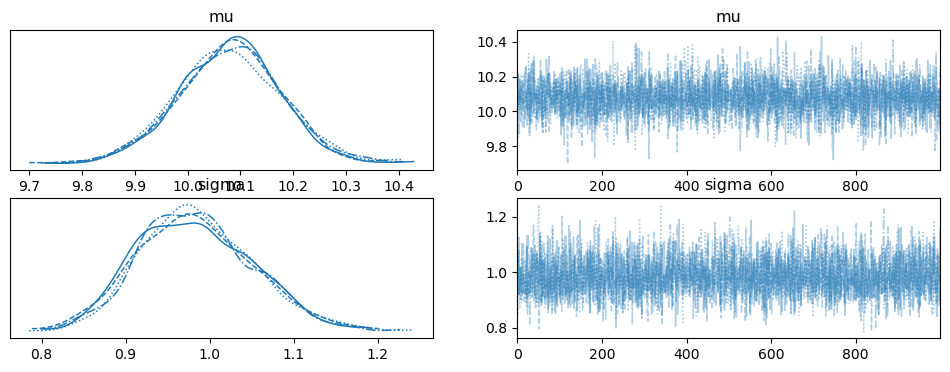

In [23]:
with Gaussian_model:
    trace_NUTS = pm.sample(1000, tune=1000, return_inferencedata=True)
    az.plot_trace(trace_NUTS);
    display(az.summary(trace_NUTS))

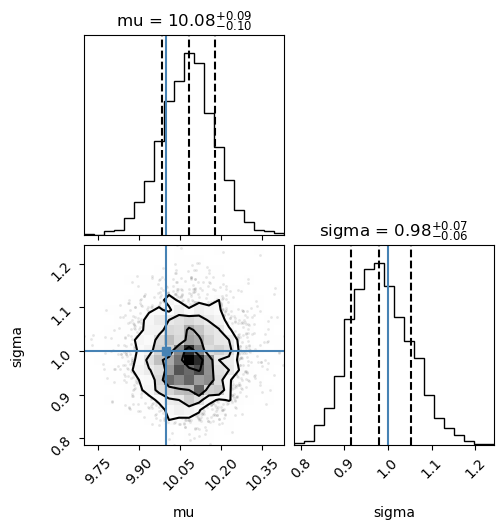

In [24]:
pymc_names = ["mu", "sigma"]
corner.corner(trace_NUTS, var_names=pymc_names, truths=[mu_true, sigma_true], quantiles=[0.16, 0.5, 0.84],
              show_titles=True);

/Users/furnstah/Dropbox/Anaconda/anaconda3/envs/8820-env/lib/python3.10/site-packages/arviz/plots/pairplot.py:232: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  gridsize = int(dataset.dims["draw"] ** 0.35)


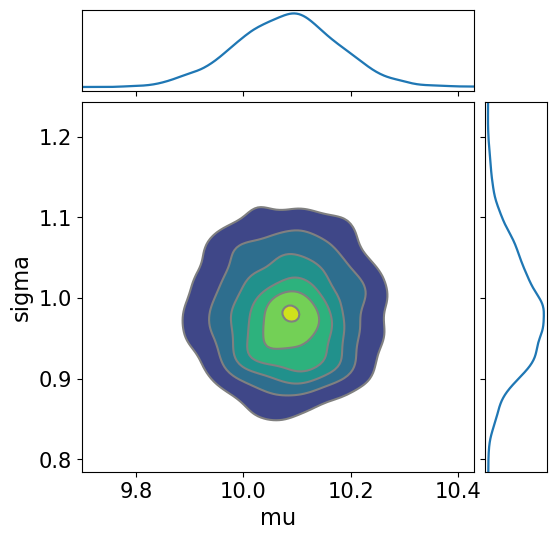

In [25]:
with Gaussian_model:
    az.plot_pair(trace_NUTS,
            kind='kde', marginals=True,
            colorbar=True,
            figsize=(6, 6))

## Discussion
Now, you might come away with the impression that the Bayesian method is unnecessarily complicated, and in this case it certainly is. Using any of these Markov Chain Monte Carlo samplers to characterize a two-dimensional normal distribution is a bit like using the Death Star to destroy a beach ball, but we did this here because it demonstrates an approach that can scale to complicated posteriors in many, many dimensions, and can provide nice results in more complicated situations where an analytic likelihood approach is not possible.